# Implementing the Ahnert and Payne scheme for a general 1-qubit  POVM on qiskit.



## Introduction

#### What is a POVM and why it is important
TODO

#### ![Image of Yaktocat](https://images.app.goo.gl/63jQGHABWWSaokmS8)

#### Implementation, general idea
TODO

In [1]:
from numpy import pi
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram


### Constructing a doubly controlled rotation gate

Before start constructing the Ahnert Payne POVM, we will create a quantum circuit performing a doubly controlled rotation on the target qubit, if the two control qubits are $ |1 \rangle$. The allowed rotations will be either z-only or y-only, unlike the qiskit u3() operation, which can perform general multi-axial rotation. However performing combinations of doubly-controlled z- and y-rotationns, we will be able to perform any doubly-controlled operation. We will need this operation when performing the t-branches operations.

Given a rotation axis $ i \in \{y,z\}$, angle $\theta$, control qubit $ q_{ctrl1}$ and $q_{ctrl2}$ and target qubit $  q_{target}$ we perform:
$ doubleCU1(i, \theta, q_{ctrl1}, q_{ctrl2}, q_{target}) =  C_{cx}(q_{ctrl1}, q_{ctrl2}, q_{target}) R_{i}( - \frac{\theta}{2}) C_{cx}(q_{ctrl1}, q_{ctrl2}, q_{target}) R_{i}(\frac{\theta}{2}) $   
where $C_{cx} $ is the Toffoli gate. 

The reasoning being, that if the two control bits are $ |1 \rangle$, the two Toffoli gate will effectively "flip" the sign of the $-\frac{\theta}{2}$ rotation hence it will add up the the first $\frac{\theta}{2}$ rotation, resulting in a total rotation of $ \theta $. Conversely if any of the control bits is not $ |1 \rangle$, the sign of the second rotation will not be flipped and both rotations will cancel out.  Note that this true only if perform single axis rotation.

In [2]:
# n-qubit control rotation gate

def nCU1(axis, angle, q_circ, ctrls, target):
    """
        Implements n-qubit controlled rotation (nCU1 )
        The rotation is single axial (unlike the qiskit multi axial rotation u3),
        Parameters:
        * axis: specifies the rotation, acceptable char values 'y' and 'z'
        (note: y and z rotation can be combined to implement any single qubit
        unitary operation)
        * angle: Bloch sphere angle specifying the rotation
        * q_circ: the quantum circuit to, which the nCU1 operation is added
        * ctrls: a list or quantum register of the control qubits.
        * target: the target qubit
    """
    n_ctrls = len(ctrls)
    list_ctrls = list(ctrls)  # a list of the qubits is easier to work with, than the QuantumRegister object
    new_ctrls = list_ctrls[:-1]  # take all control qubits references but the last one

    if n_ctrls >= 2:

        nCU1(axis, angle/2, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
        nCU1(axis, -angle / 2, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
    elif n_ctrls == 1:

        if axis == 'y':
#             q_circ.cu3(angle, 0, 0, list_ctrls[0], target)
            q_circ.u3(angle/2, 0, 0, target)
            q_circ.cx(list_ctrls[0], target)
            q_circ.u3(-angle/2, 0, 0, target)
            q_circ.cx(list_ctrls[0], target)
            
        elif axis == 'z':
#             q_circ.cu3(0, 0, angle, list_ctrls[0], target)
            q_circ.u3(0,0,angle/2, target)
            q_circ.cx(list_ctrls[0], target)
            q_circ.u3(0,0,-angle/2, target)
            q_circ.cx(list_ctrls[0], target)
            
        else:
            raise ValueError('Invalid value for axis!')
    else:

        if axis == 'y':
            q_circ.u3(angle, 0, 0, target)
        elif axis == 'z':
            q_circ.u3(0, 0, angle, target)
        else:
            raise ValueError('Invalid value for axis!')

    return 1

### Construct a 2-element POVM module

In [3]:
def first_AP_module_new(qc, q, tita1, tita2):  # "theta" not "tita"
    """ Implements a first module of Ahenrt Payne POVM.

        qc: existing q-circuit

        q: is a register of at least 3 qubit objects.
        q[0] represents the state being measured 
        q[1] is ancilla qubit, used to represent the output branches. It should be in the zero state
        
        The POVM outputs correspond to the following values of q1:
            branch p1: 0
            branch p2: 1

        theta1 and theta2 specify POVMs 1 and 2(see above)
        (future version will allow for phase operations, specified by phi1 and phi2)
    """

    # Apply the rotations along p1 and p2

    # controlled rotation if qubit 0 is ZERO
    qc.x(q[0])
    nCU1('y', 2*tita1, qc,[q[0]],q[1]) 
    qc.x(q[0])
#     qc.barrier(q)

    # controlled rotation if qubit 0 is ONE
    nCU1('y', 2*tita2, qc,[q[0]],q[1])
#     qc.barrier(q)


## Assemble a circuit for a 2-element POVM

In [4]:
q = QuantumRegister(2, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)

# prepare the input state (the input state will be represented by qubit 0)
qc.u3(pi*2/3, 0 ,0, q[0])

# Apply the POVM
first_AP_module_new(qc,q,pi/4,pi/4)

# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(2, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)

# map the quantum measurement to the classical bits
meas.measure(q,c)

qc = qc+meas

circuit_drawer(qc)


### Run a simulation

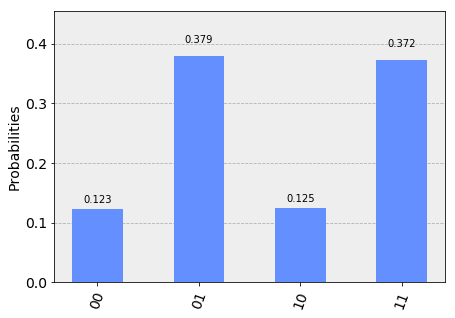

In [5]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8096

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

### Run on a real device

In [11]:
from qiskit import IBMQ
# IBMQ.save_account("token")
# IBMQ.update_account()
IBMQ.load_account()
# IBMQ.stored_accounts()

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [14]:
q_circshots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_ourense') # choose which device; see IBMQ website for names and availability

print(backend)

<IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>

In [15]:
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

In [ ]:
counts = result.get_counts(qc)
plot_histogram(counts)

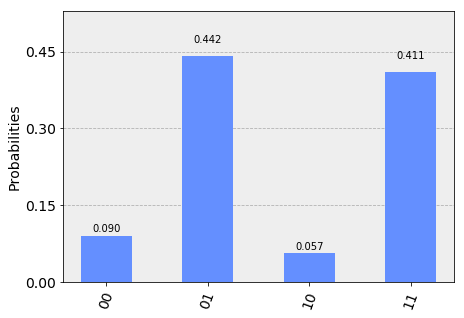

In [9]:
# ibmqx2

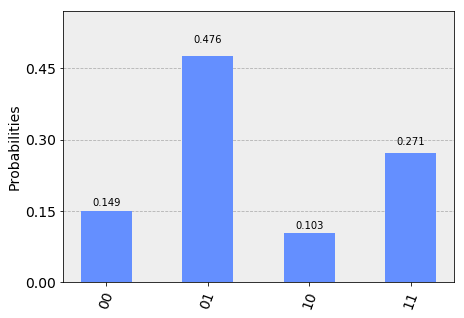

In [16]:
# ibmq_ourense

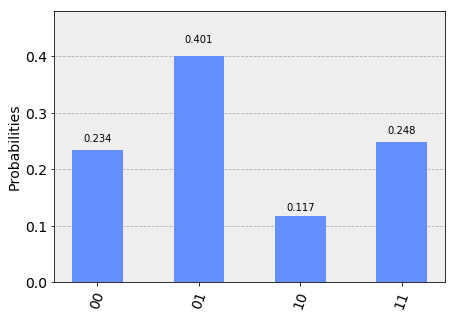

In [79]:
# ibmq_ourense

### 3 Part POVM

#### Example
Here we implement a 3-element POVM with projective measurement operators, projecting at three states in the x-z Block plane, separated by $120^o$. This a common example from literature used to illustrate how POVMs can be used in distinguishing non-orthogonal states.

#### Implementation
TODO: explain ... give reference to the citation


In [4]:
def second_AP_module_new(qc, q, tita3, tita4):
    """ Implements a second module of Ahenrt Payne POVM.

        qc: existing q-circuit

        q: is a register of at least 4 qubit objects.
        q[0] represents the state being measured 
        q[1], q[2] are ancilla qubits, used to represent the output branches. They should be in the zero state
        q[3], is another ancilla qubit, required for intermidiate operations. It should be in zero state too
        
        The outputs (branches) correspond to the following values of q1q2:
            branch p1: 00
            branch p2: 10
            branch p3: 11

        tita3 and tita4 specify POVMs 3 and 4(see above)
        (future version will allow for phase operations, specified by phi2 and phi3)
    """

    # Apply the rotations along p1' and p2'

    # Rotation along p1' branch
    qc.x(q[0])
    nCU1('y', 2*tita3, qc,[q[1], q[0]],q[2])
    qc.x(q[0])

    # rotation along p2' branch
    nCU1('y', 2*tita4,qc ,[q[1], q[0]],q[2])



#### Example:

As an example we implement the popular case of nonorthogonal 3 part POVM along axes separated by $ 120^o $ in the $ xz $ plane of the Block sphere. 

In [5]:
# angle parameters for the 1st and 2nd panel
tita1 = np.arccos(np.sqrt(2/3))
tita2 = pi/2
tita3 = 0
tita4 = pi/2

# Ui and Uii are implemented as controled rotations as well. 
# In our example Ui = I, so no action needed
# For Uii required y rotation at -pi/2 rads 

alpha_ui = 0
alpha_uii = -pi/2

In [6]:
# Create a Quantum Register with 4 qubits.
q = QuantumRegister(3, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)

# qc.u3(0, 0, 0, q[0])  # INITIAL STATE!

# Apply Ui
# qc.u3(alpha_ui, 0, 0, q[0])  # for the sake of clarity

# Apply the 1st AnP panel
first_AP_module_new(qc,q,tita1,tita2)
    
# Apply Uii, require a single qubit controled rotation 
nCU1('y', alpha_uii, qc, [q[1]], q[0])     

# Apply 2nd Ahnert Payne POVM module
second_AP_module_new(qc, q, tita3, tita4)




At this point we have obtained the desired POVMs $F_1, F_2$ and $F_3$. However they do not completerly define the measurement operators $ M_1, M_2 $ and $ M_3 $. To fully specify the measurements we need to perform $ T_1 , T_2, T_3 $ unitary operations to each of the 3 outputs. 

In the case of three measurements corresponding to axes $ 120^o$ apart, one of which is along the $z_+$ axis we need to perform the following T operations:

(this is wrong)

$ T_1 = I = \left( \begin{smallmatrix} 1&0\\ 0&1 \end{smallmatrix} \right)$ , $ T_2 = \frac{1}{2} \left( \begin{smallmatrix} 1& -\sqrt{3}\\ \sqrt{3}&1 \end{smallmatrix} \right)$,  $ T_3 = \frac{1}{2} \left( \begin{smallmatrix} 1& \sqrt{3}\\ -\sqrt{3}&1 \end{smallmatrix} \right)$ 

To perform this operations we use our n-qubit controled rotation. We perform y-axis rotation at angles $ 0 ,\frac{2\pi}{3}, \frac{-2\pi}{3} $ respectevely, with control qubits $ { q_1, q_2 } $ and target qubit $ q_0 $. Again we use X gates to tackle the values of the control qubits. 


In [7]:
# perform T2 on p2 branch, correspond to 10 value of q1q2
qc.x(q[2])
# nCU1('y', 2*pi/3, qc, [q[1], q[2]], q[0] )
nCU1('y', 2*pi/3, qc, [q[1], q[2]], q[0] )
qc.x(q[2])

# perform T3 on p3 branch, correspond to 11 value of q1q2
# nCU1('y', -2*pi/3, qc, [q[1], q[2]], q[0] )  # changee???
nCU1('y', 7*pi/3, qc, [q[1], q[2]], q[0] )

# 11->01
qc.cx(q[2],q[1])


In [8]:
# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(3, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)

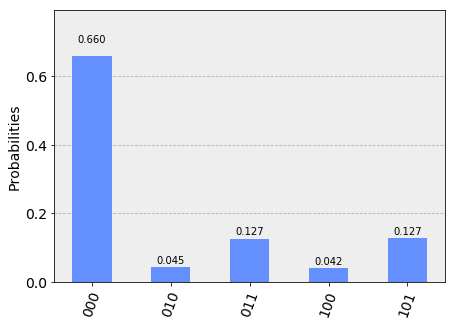

In [14]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8192

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

In [66]:
counts

{'000': 5507, '101': 172, '100': 2513}

In [16]:
# IBMQ.save_account(token)
IBMQ.load_account()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3


# large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] >= n_qubits and
#                                                        not x.configuration()['simulator'])
# backend = least_busy(large_enough_devices)
backend = IBMQ.backends(name = 'ibmqx2')[0]
print("The best backend is " + backend.name())

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:547: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)


The best backend is ibmqx2


In [17]:
# Hello there
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

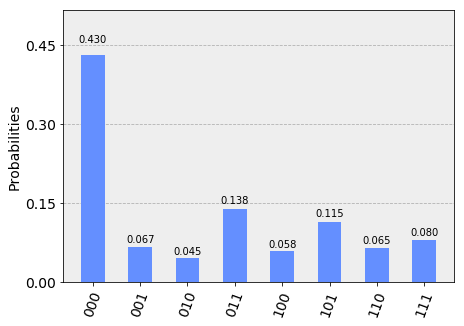

In [18]:
counts = result.get_counts(qc)
plot_histogram(counts)

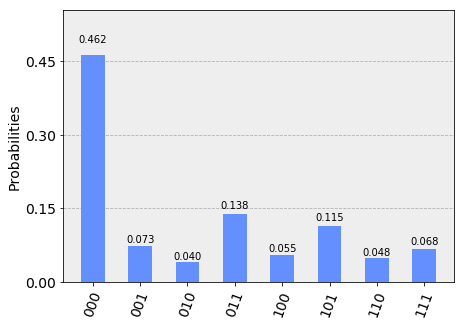

In [12]:
#ibmqx2